## 1 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/Challenge2

Mounted at /gdrive
/gdrive/My Drive/Challenge2


## 2 Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configure plot display settings
# sns.set(font_scale=1.4)
# sns.set_style('white')
# plt.rc('font', size=14)
# %matplotlib inline

## ⏳ Load the Data

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## 3 Load Data

In [ ]:
# data loading
data = np.load("mars_for_students.npz")
training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]
y_train=y_train.astype(np.int32) # classes as integer numbers

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
# Define a mapping of labels to their corresponding digit names
classes = {0: 'Background', 1: 'Soil', 2: 'Bedrock', 3: 'Sand', 4: 'Big Rock'}
print(classes)

{0: 'Background', 1: 'Soil', 2: 'Bedrock', 3: 'Sand', 4: 'Big Rock'}


## 4 Inspect Data

### 4.1 PCA

Percentage of variance explained by the principal components: [0.59952449 0.06193483]


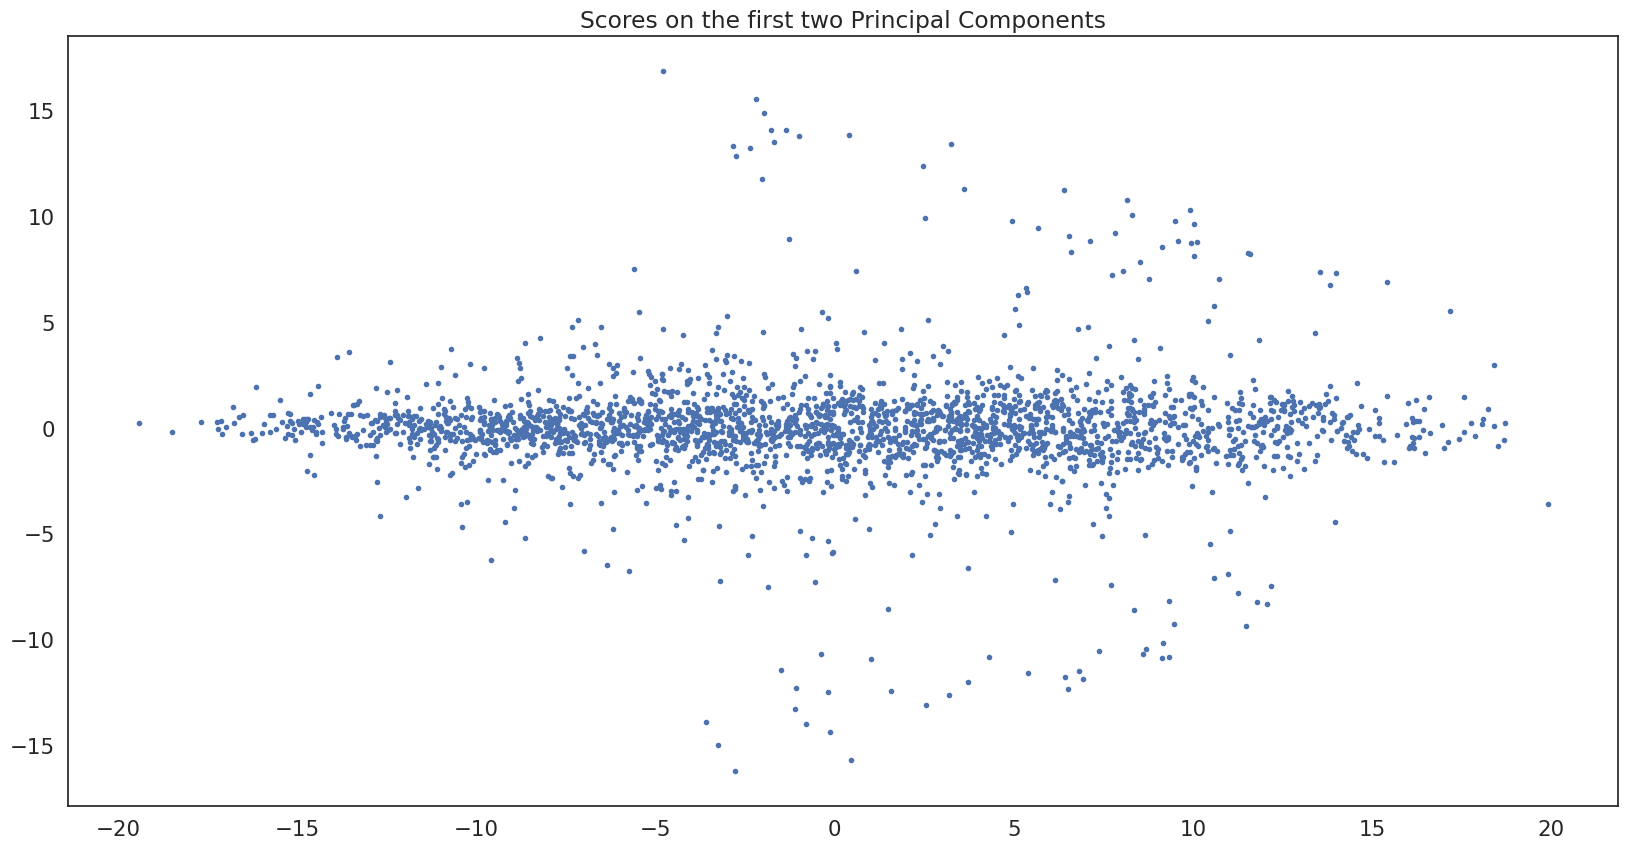

In [ ]:
# performing PCA to detect aoutliers
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.manifold import TSNE
if np.max(X_train) > 1:
    X_train = X_train/255
images_flat = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))

# Apply PCA
pca = PCA(n_components=2)
pca.fit(images_flat)
print("Percentage of variance explained by the principal components:",pca.explained_variance_ratio_)
scores = pca.transform(images_flat)

# Plot
plt.figure(figsize=[20,10])
plt.title('Scores on the first two Principal Components')
plt.plot(scores[:,0],scores[:,1], 'b.')
plt.show()

## 5 Process Data

### 5.1 Outliers removal

2505
(2505, 64, 128)
(2505, 64, 128)


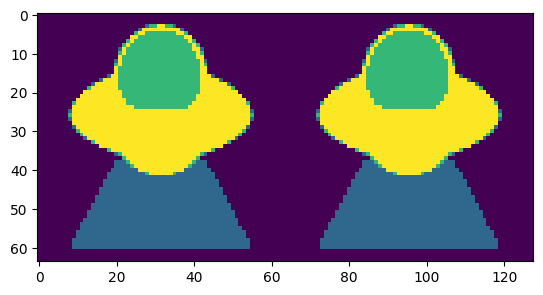

In [ ]:
# remuval of outliers (see the other notebook for the complete process)
Alien = y_train[79]
plt.figure()
plt.imshow(Alien)

# remove outliers
idxRemove = []
for i, img in enumerate(y_train):
  if np.array_equal(img, Alien):
    idxRemove.append(i)

X_train = np.delete(X_train, idxRemove, axis = 0)
y_train = np.delete(y_train, idxRemove, axis = 0)

print(len(y_train))
print(np.shape(y_train))
print(np.shape(X_train))


### 5.2 Colormap definition

In [ ]:
# funtion to define the segmentation colormap
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

# function to apply the colormap
def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)


    if colormap is None:
        colormap = create_segmentation_colormap(5)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored


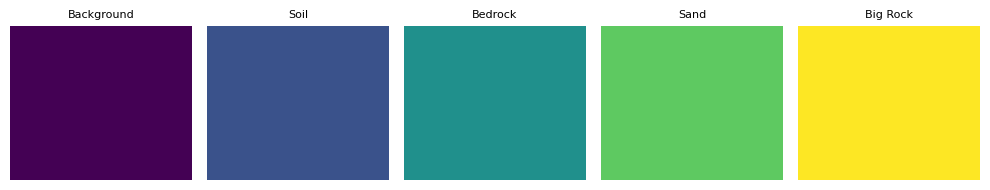

In [ ]:
# function to visualize the colormap
def visualize_colormap(colormap, num_classes):
    """
    Visualize the colormap and its association with class indices.
    """
    plt.figure(figsize=(10, 2))
    for i, color in enumerate(colormap):
        plt.subplot(1, num_classes, i + 1)
        plt.imshow([[color]], aspect='auto')
        plt.axis('off')
        plt.title(classes[i], fontsize=8)
    plt.tight_layout()
    plt.show()

# number of classes
num_classes = 5

# generates the colormap
colormap = create_segmentation_colormap(num_classes)

# visualization of the colormap
visualize_colormap(colormap, num_classes)

### 5.3 Data visualization

In [ ]:
# function to plot some images
def plot_sample_batch(images,labels):
    """
    Display some image and label pairs from the dataset.
    """
    num_samples=len(images)
    plt.figure(figsize=(15, 4*num_samples))
    colormap = create_segmentation_colormap(5)
    #print(np.shape(images))
    if np.shape(images)==(64, 128):
      plt.subplot(1,2,1)
      plt.imshow(X_train[31],cmap='gray')
      plt.axis('off')

      plt.subplot(1,2,2)
      plt.imshow(apply_colormap(y_train[31]))
      plt.axis('off')
      plt.show()
      plt.close()
    else:
      print(len(images))
      for j in range(len(images)):
          # Plot original image
          plt.subplot(num_samples, 2, j*2 + 1)
          plt.imshow(images[j],cmap='gray')
          plt.title(f'Image {j+1}')
          plt.axis('off')

          # Plot colored label
          plt.subplot(num_samples, 2, j*2 + 2)
          #print(np.shape(labels[j]))
          colored_label = apply_colormap(labels[j], colormap)
          plt.imshow(colored_label)
          plt.title(f'Label {j+1}')
          plt.axis('off')

      plt.tight_layout()
      plt.show()
      plt.close()
# Visualize examples from the training set

# images=X_train[index]# così l'ultimo indice è escluso
# labels=y_train[index]
# print("Visualizing examples from the training set:")
# plot_sample_batch(images,labels)

### 5.4 Class distribution

In [ ]:
# visualizing the class distribution
unique, count = np.unique(y_train, return_counts=True)
print('Target labels:', unique)
for i in range(len(unique)):
    print(f'Class {unique[i]} has {count[i]} samples')

Target labels: [0 1 2 3 4]
Class 0 has 4988826 samples
Class 1 has 6957538 samples
Class 2 has 4776810 samples
Class 3 has 3770823 samples
Class 4 has 26963 samples


### 5.5 Normalizing and rescaling data

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0
y_train=y_train[..., np.newaxis]

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


## 6 Define Network Parameters

In [ ]:
# Set batch size for training
batch_size = 32

# Set learning rate for the optimiser
learning_rate = 1e-3

# Set early stopping patience threshold
patience = 15

# Set maximum number of training epochs
epochs = 300

## 7 Label Refinement

### 7.1 Label correction for general images

In [ ]:
# Corretting labeles what were highly imprecise
from sklearn.utils import shuffle

data_bigrocks = np.load("updated_dataset_orrible.npz")

X_0 = data_bigrocks["X"]
Y_0 = data_bigrocks["Y"]

X_0 = X_0[..., np.newaxis] / 255.0
Y_0=Y_0[..., np.newaxis]
print(len(X_0))

X_0[21] # wrong label that we remove
X_0 = np.delete(X_0, [21], axis=0)
Y_0 = np.delete(Y_0, [21], axis=0)


for i in range(len(X_0)):
  imag_nuova=X_0[i]
  indices_to_remove = []
  for i, img in enumerate(X_train):
      if np.array_equal(img, imag_nuova):
          indices_to_remove.append(i)

  X_train = np.delete(X_train, indices_to_remove, axis=0)
  y_train = np.delete(y_train, indices_to_remove, axis=0)
  #print(indices_to_remove)

X_train=np.concatenate([X_train, X_0],axis=0)
y_train=np.concatenate([y_train, Y_0],axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=42)

39


### 7.2 Label correction for images with class 4

In [ ]:
# Correcting labels of some images containing big rocks (class 4)

data_bigrocks = np.load("updated_dataset.npz")

# extraction of datas X and Y
X = data_bigrocks["X"]
Y = data_bigrocks["Y"]

X = X[..., np.newaxis] / 255.0
Y=Y[..., np.newaxis]



for i in range(len(X)):
  imag_nuova=X[i]
  indices_to_remove = []
  for i, img in enumerate(X_train):
      if np.array_equal(img, imag_nuova):
          indices_to_remove.append(i)

  X_train = np.delete(X_train, indices_to_remove, axis=0)
  y_train = np.delete(y_train, indices_to_remove, axis=0)
  print(indices_to_remove)

X_train=np.concatenate([X_train, X],axis=0)
y_train=np.concatenate([y_train, Y],axis=0)

# shuffling the images so we don't have them all in the same batch
X_train, y_train = shuffle(X_train, y_train, random_state=42)

## 8 Data Splitting

In [ ]:
# Split into training, validation, and test sets
split_size = 300

print("Splitting data...")
# X_train_val, X_testing, y_train_val, y_testing = train_test_split(
#     X_train, y_train, test_size=100, random_state=seed
# )
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=split_size, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
#print(f"Test: {len(X_testing)}")

Splitting data...
Data splitted!

Number of images:
Train: 2205
Validation: 300


## 9 Augmentation

In [ ]:
# definition of random flip left to right
def random_flip_lr(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)

    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image), #if the condition is true it does the first function, otherwise the second one
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [ ]:
# definition of random flip up to down
def random_flip_ud(image, label, seed = seed):
    """Consistent random horizontal flip."""
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(label),
        lambda: label
    )
    return image, label

In [ ]:
# other augmentation definition not used in the end
# def aug_rot(image, label, seed=seed):
#     # Crea un generatore randomico con il seed fornito
#     use_prob = tf.random.uniform([],seed=seed)
#     rotation_angle = tf.random.uniform([], minval=-0.3, maxval=0.3,seed=seed)

# # fill_mode: str = 'reflect',

#     image = tf.cond(
#         use_prob > 0.5,
#         lambda: tfa.image.rotate(image, rotation_angle,fill_mode='reflect'),
#         lambda: image
#     )
#     label = tf.cond(
#         use_prob > 0.5,
#         lambda: tfa.image.rotate(label, rotation_angle,fill_mode='reflect'),
#         lambda: label
#     )


#     return image, label

In [ ]:
def flipping(image, label, seed = seed):
  image, label=random_flip_lr(image, label, seed=seed)
  image, label=random_flip_ud(image, label, seed=seed)
  return image, label

In [ ]:
# We now add multiple times the hand-made images with big_rocks to balance the dataset

index=[];
for i in range(len(y_train)): # starts from 0 nd arrives to len(X_train)-1
  if (np.any(y_train[i]==4)==True):
    index.append(i)


dataset = tf.data.Dataset.from_tensor_slices((X, Y))
dataset = dataset.map(
    lambda x, y: flipping(x, y),
)


image_tensor = tf.stack([x for x, _ in dataset],axis=0)
label_tensor = tf.stack([y for _, y in dataset],axis=0)

# conversion to numpy arrays
image_array = image_tensor.numpy()
label_array = label_tensor.numpy()

# conversion only to apply the augmentation and then going back to ndarray

for i in range(4):
    X_train=np.concatenate([X_train, image_array],axis=0)
    y_train=np.concatenate([y_train, label_array],axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [ ]:
def one_hot_encode(image, label):
    label = tf.squeeze(label, axis=-1)
    label = tf.one_hot(label, depth=5)  # Convert to one-hot
    return image, label

# Map the one-hot encoding function to the dataset

## 10 Making the dataset

In [ ]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 3, seed=seed)

    if augment:
        dataset = dataset.map(
            lambda x, y: flipping(x, y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset = dataset.map(one_hot_encode,num_parallel_calls=tf.data.AUTOTUNE)


    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Training dataset (augmentation)
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=True,
    augment=True,
    seed=seed
)

# Validation dataset (no augmentation)
val_dataset = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .map(one_hot_encode, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## 11 Train and Save the Model

### 11.1 Model implementation

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, initializer=None,regularizer=None, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same',kernel_initializer=initializer, kernel_regularizer=regularizer, name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
# network definition
def get_unet_model2(input_shape=(64, 128, 1), num_classes=5, seed=seed):
    tf.random.set_seed(seed)
    initializer=tfk.initializers.HeNormal(seed=seed)

    l2_lambda=1e-4
    regularizer = tfk.regularizers.l2(l2_lambda)

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')


    x=input_layer
    # augmentation = tf.keras.Sequential([
    #     tfkl.RandomContrast(0.3),
    #     ], name='preprocessing')
    # x = augmentation(input_layer)



    # Downsampling path
    down_block_1 = unet_block(x, 32, initializer=initializer,name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, initializer=initializer,name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, initializer=initializer,name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck
    bottleneck = unet_block(d3, 256, initializer=initializer, regularizer=regularizer, name='bottleneck')


    u1 = tfkl.UpSampling2D(size=(2, 2),interpolation="nearest")(bottleneck)
    u1=tfkl.Conv2D(filters=128,kernel_size=3,padding="same",kernel_initializer=initializer)(u1)
    u1 = tfkl.Concatenate()([u1, down_block_3])
    u1 = unet_block(u1, 128,initializer=initializer, regularizer=regularizer,name='up_block1_')

    u2 = tfkl.UpSampling2D(size=(2, 2),interpolation="nearest")(u1)
    u2=tfkl.Conv2D(filters=64,kernel_size=3,padding="same",kernel_initializer=initializer)(u2)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64,initializer=initializer, name='up_block2_')

    u3=tfkl.UpSampling2D(size=(2, 2),interpolation="nearest")(u2)
    u3=tfkl.Conv2D(filters=32,kernel_size=3,padding="same",kernel_initializer=initializer)(u3)
    u3 = tfkl.Concatenate()([u3, down_block_1])
    u3 = unet_block(u3, 32,initializer=initializer, name='up_block3_')


    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

[0 1 2 3 4]
[0.0, 4.0, 5.0, 5.5, 50.0]


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_15       │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d_15[0… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 2,145,829 (8.19 MB)

 Trainable params: 2,143,013 (8.17 MB)

 Non-trainable params: 2,816 (11.00 KB)

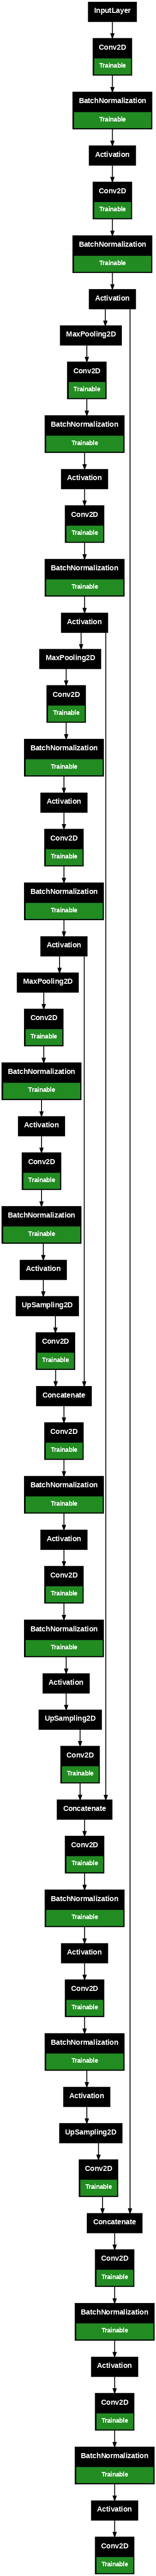

In [ ]:
import sklearn
model = get_unet_model2()
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False,sparse_y_true=False, name='mean_iou')
optimizer=tfk.optimizers.Adam(learning_rate=0.001)

y_flat=y_train.reshape(-1)
classes=np.unique(y_flat)
print(classes)

# class_weights=sklearn.utils.class_weight.compute_class_weight(class_weight='balanced',classes=classes, y=y_flat)
# alpha = list(class_weights)

alpha=[0.,4.,5.,5.5,50.]
print(alpha)
loss=tfk.losses.CategoricalFocalCrossentropy(
    alpha=alpha,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction="sum_over_batch_size",
    name="categorical_focal_crossentropy",
    dtype=None,
)

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy",mean_iou])

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

### 11.2 Callbacks setup

In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=15,
    restore_best_weights=True
)
reduce_LR_onPlat=tfk.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=8,
    verbose=0,
    mode="max",
    min_delta=0.0015,
    cooldown=0,
    min_lr=5e-5
)


callbacks=[early_stopping, reduce_LR_onPlat]

### 11.3 Model training

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 374ms/step - accuracy: 0.3669 - loss: 3.4155 - mean_iou: 0.2097 - val_accuracy: 0.1761 - val_loss: 23.2151 - val_mean_iou: 0.0502 - learning_rate: 0.0010
Epoch 2/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.4818 - loss: 1.9930 - mean_iou: 0.3902 - val_accuracy: 0.2259 - val_loss: 8.6711 - val_mean_iou: 0.1134 - learning_rate: 0.0010
Epoch 3/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.4647 - loss: 2.0011 - mean_iou: 0.3702 - val_accuracy: 0.1686 - val_loss: 6.7667 - val_mean_iou: 0.0606 - learning_rate: 0.0010
Epoch 4/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.5100 - loss: 1.6954 - mean_iou: 0.4258 - val_accuracy: 0.2303 - val_loss: 3.5033 - val_mean_iou: 0.1509 - learning_rate: 0.0010
Epoch 5/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.5456 - loss: 1.4464 - mean_iou: 0.4702 - val_accuracy: 0.4004 - val_loss: 2.2646 - val_mean_iou: 0.2948 - learning_rate: 0.0010
Epoch 6/300
73/73 ━━━━━━━

### 11.4 Plot training and validation loss

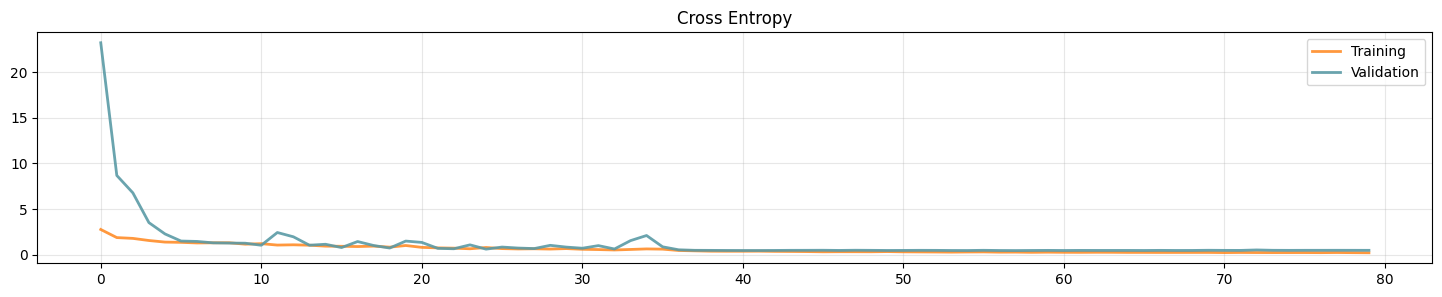

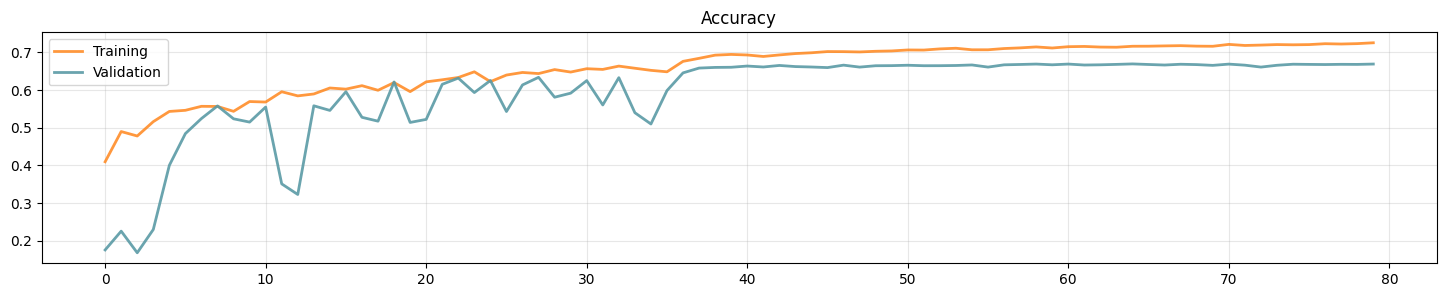

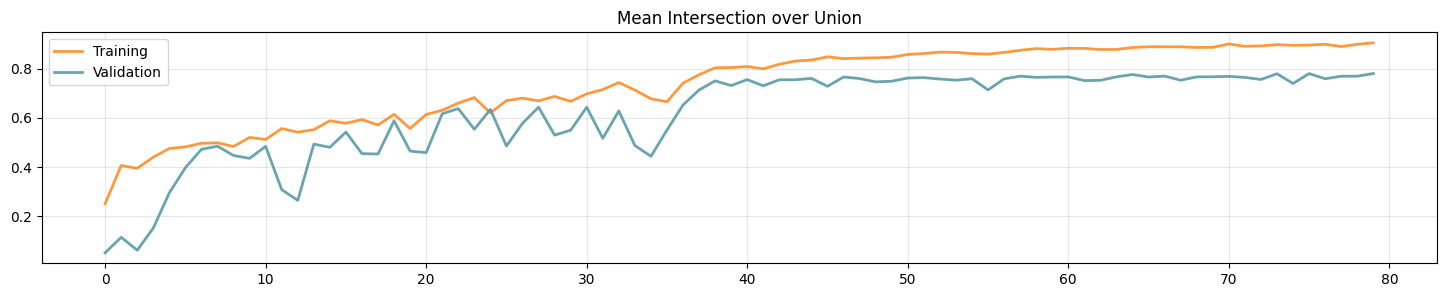

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Test predictions

In [ ]:
# Used in development phase, then for the submission we removed the local test set

model = tfk.models.load_model('UNet_64.31.keras', compile=True)
y_true=y_testing
m = tfk.metrics.IoU(num_classes=5, target_class_ids=[1,2,3,4],ignore_class=0, sparse_y_pred=True)
m = tfk.metrics.MeanIoU(num_classes=5, ignore_class=0, sparse_y_pred=True)

y_pred= model.predict(X_testing, verbose=0)
y_pred = tf.math.argmax(y_pred, axis=-1)

m.update_state(y_true,y_pred)
print(m.result().numpy())
m.reset_state()

In [ ]:
m = tfk.metrics.IoU(num_classes=5, target_class_ids=[4],ignore_class=0, sparse_y_pred=True)

m.update_state(y_true, y_pred)
print(m.result().numpy())
m.reset_state()

0.36378464


In [ ]:
m = tfk.metrics.IoU(num_classes=5, target_class_ids=[1,2,3,4],ignore_class=0, sparse_y_pred=True)
m.update_state(y_true, y_pred)
print(m.result().numpy())
m.reset_state()

0.5862401


## 12 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
print(model_filename)

UNet_78.1.keras


Ensamble of two models

In [ ]:
# We load our best models in order to make an ensemble of their predictions

model1 = tfk.models.load_model('UNet_78.1.keras')
#model2=tfk.models.load_model('UNet_64.31.keras')
model3=tfk.models.load_model('UNet_78.07.keras')


In [ ]:
preds1 = model1.predict(X_test)
#preds2 = model2.predict(X_test)
preds3= model3.predict(X_test)
preds=preds1+preds3
print(np.shape(preds))
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step
(10022, 64, 128, 5)
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
#timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_ensemble3.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

# from google.colab import files
# files.download(submission_filename)


#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```